In [22]:
# install pytorchfire and dependencies

%pip install 'pytorchfire[examples]'
%pip install requests
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [23]:
# download the dataset

map_name = 'Bear_2020'

import requests

def download_file(url, filename):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    
    with open(filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

file_url = f'https://github.com/xiazeyu/PyTorchFire/raw/refs/heads/jupyter-examples/examples/{map_name}.npz'
filename = f'{map_name}.npz'
download_file(file_url, filename)

print(f"Dataset downloaded and saved as {filename}")


Dataset downloaded and saved as Bear_2020.npz


In [24]:
# load the dataset
import numpy as np

ds = np.load('Bear_2020.npz')

print('Dataset keys:', ds.files)

p_veg = ds['p_veg']
p_den = ds['p_den']
wind_towards_direction = ds['wind_towards_direction']
wind_velocity = ds['wind_velocity']
slope = ds['slope']
initial_ignition = ds['initial_ignition']

a = ds['a']
p_h = ds['p_h']
p_continue = ds['p_continue']
c_1 = ds['c_1']
c_2 = ds['c_2']

wind_step_interval = ds['wind_step_interval']
max_steps = ds['max_steps']

Dataset keys: ['a', 'c_1', 'c_2', 'max_steps', 'p_continue', 'p_h', 'wind_step_interval', 'initial_ignition', 'p_den', 'p_veg', 'slope', 'wind_towards_direction', 'wind_velocity']


In [25]:
# run the simulation

from pytorchfire import WildfireModel
from tqdm import tqdm
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

model = WildfireModel({
        'p_veg': torch.tensor(p_veg),
        'p_den': torch.tensor(p_den),
        'wind_towards_direction': torch.tensor(wind_towards_direction[0]),
        'wind_velocity': torch.tensor(wind_velocity[0]),
        'slope': torch.tensor(slope),
        'initial_ignition': torch.tensor(initial_ignition, dtype=torch.bool)
    }, {
        'a': torch.tensor(a),
        'p_h': torch.tensor(p_h),
        'p_continue': torch.tensor(p_continue),
        'c_1': torch.tensor(c_1),
        'c_2': torch.tensor(c_2),
    })

model.to(device)
model.eval()

affected_cell_count_outputs = []
affected_cell_count_targets = []

postfix = {}
output_list = []

with tqdm(total=max_steps) as progress_bar:
        with torch.no_grad():
            for steps in range(max_steps):
                postfix['steps'] = f'{steps + 1}/{max_steps}'

                if steps % wind_step_interval == 0:
                    model.wind_towards_direction = torch.tensor(
                        wind_towards_direction[steps // wind_step_interval], device=device)
                    model.wind_velocity = torch.tensor(wind_velocity[steps // wind_step_interval],
                                                            device=device)

                model.compute()
                outputs = model.state[0] | model.state[1]

                postfix['burning'] = model.state[0].sum().detach().cpu().item()
                postfix['burned'] = model.state[1].sum().detach().cpu().item()

                output_list.append(outputs.cpu().detach().numpy())

                progress_bar.set_postfix(postfix)
                progress_bar.update(1)


Using device: cpu


100%|██████████| 300/300 [00:14<00:00, 20.14it/s, steps=300/300, burning=1362, burned=141644]


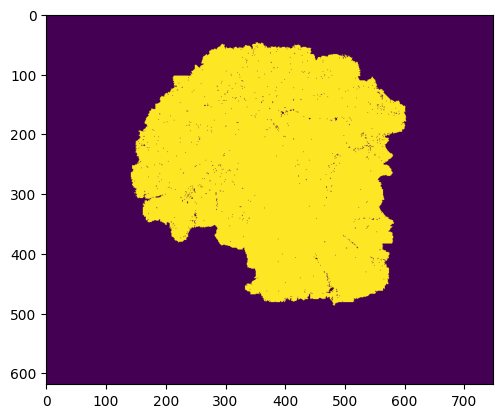

In [26]:
# Visualize the simulation

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()

im = ax.imshow(output_list[0])

def update(frame):
    im.set_array(output_list[frame])
    return [im]

ani = FuncAnimation(
    fig, update, frames=len(output_list), interval=100, blit=True
)

ani.save('prediction.gif', fps=10)
HTML(ani.to_jshtml())

![Animation](prediction.gif)